In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Thu Aug 10 07:46:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:65:00.0  On |                  Off |
| 30%   33C    P0    56W / 450W |    288MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [58]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision, torchvision.transforms as transforms

from diffusers import AutoencoderKL

In [51]:
def display_images(tensor, max_per_row=6):
    """Displays a grid of images with at most max_per_row images per row.

    Args:
        tensor (torch.Tensor): A tensor of shape (n_images, 3, 32, 32) containing the images.
        max_per_row (int): The maximum number of images to display per row.
    """
    n_images, channels, height, width = tensor.shape
    assert channels == 3, "Expected 3 channels (RGB) in the input tensor"

    # Set tensor to cpu
    if tensor.is_cuda:
        tensor = tensor.cpu()
    
    # Calculate the number of rows and columns required for the grid
    n_rows = (n_images // max_per_row) + int(n_images % max_per_row > 0)
    n_cols = min(max_per_row, n_images)

    # Create a figure and set the size to fill the jupyter cell output
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    # Adjust the spacing between subplots to reduce gaps
    plt.subplots_adjust(wspace=0.02, hspace=0.05)

    # Flatten the axes array and remove any extra unused axes
    axes = axes.flatten()
    for ax in axes[n_images:]:
        ax.axis('off')

    # Iterate through images and display them on the grid
    for i in range(n_images):
        ax = axes[i]
        image = tensor[i].permute(1, 2, 0).numpy()  # Permute the image to the shape (32, 32, 3)
        image_min, image_max = image.min(), image.max() # normalize image's pixel values
        image = (image - image_min) / (image_max - image_min) if image_max > image_min else image
        ax.imshow(image)
        ax.axis('off')

    plt.show()

In [52]:
def save_model_architecture(filepath, model):
    with open(filepath, 'w') as f:
        f.write(str(model))

def write_to_file(filepath, text):
    with open(filepath, 'a') as file:
        file.write(text + '\n')

# Cifar10

Get pretrained vae.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-2", subfolder="vae").to(device)

Get cifar10 dataset.

In [6]:
image_size = 32

preprocess_images = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

cifar10_tensor = torch.stack([x[0] for x in torchvision.datasets.CIFAR10(root='./data', transform=preprocess_images, download=True)]).to(device)

Files already downloaded and verified


Based on some tests, the vae should be able to produce latents for a batch and then sample from that batch.

So for efficiency that is what we will do in our function to create latents.

In [7]:
def create_latents_from_vae(vae, data_tensor):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vae.to(device)
    data_tensor.to(device)
    
    latents = []
    for sample in tqdm(data_tensor, desc="Latents", ncols=100):
        with torch.no_grad():
            latents.append(vae.encode(sample.unsqueeze(0)).latent_dist.sample())
    latents = torch.cat(latents, dim=0)
    
    return latents

Try function.

In [57]:
cifar10_latents = create_latents_from_vae(vae, cifar10_tensor)

Latents: 100%|███████████████████████████████████████████████| 50000/50000 [02:42<00:00, 307.53it/s]


In [58]:
cifar10_latents.shape

torch.Size([50000, 4, 4, 4])

Save latents

In [59]:
save_path = "data/cifar10_latents.pth"
torch.save(cifar10_latents, save_path)

## (SKIP HERE) Load cifar10 latents

In [8]:
save_path = "data/cifar10_latents.pth"
cifar10_latents = torch.load(save_path)

# Reconstruction w/ Pretrained VAE

In [12]:
def decode_latents(vae, latents_tensor):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vae.to(device)
    latents_tensor.to(device)
    
    decoded = []
    for sample in tqdm(latents_tensor, desc="Decoding", ncols=100):
        with torch.no_grad():
            decoded.append(vae.decode(sample.unsqueeze(0)).sample)
    decoded = torch.cat(decoded, dim=0)
    
    return decoded

In [13]:
cifar10_reconstructed = decode_latents(vae, cifar10_latents)

Decoding: 100%|██████████████████████████████████████████████| 50000/50000 [03:27<00:00, 240.63it/s]


Calculate reconstruction error, using l1 loss.

In [16]:
cifar10_tensor.shape

torch.Size([50000, 3, 32, 32])

In [15]:
cifar10_reconstructed.shape

torch.Size([50000, 3, 32, 32])

In [98]:
reconstruction_error = nn.L1Loss(reduction='sum')(cifar10_tensor, cifar10_reconstructed)
print("Reconstruction error of 50k cifar10 samples:", reconstruction_error)

Reconstruction error of 50k cifar10 samples: tensor(37028840., device='cuda:0')


Reconstruction steps:
- encode image tensor to a latent gaussian distribution using the vae's encoder
- randomly sample from this latent distribution
- decode the sampled latent vector to reconstruct the image

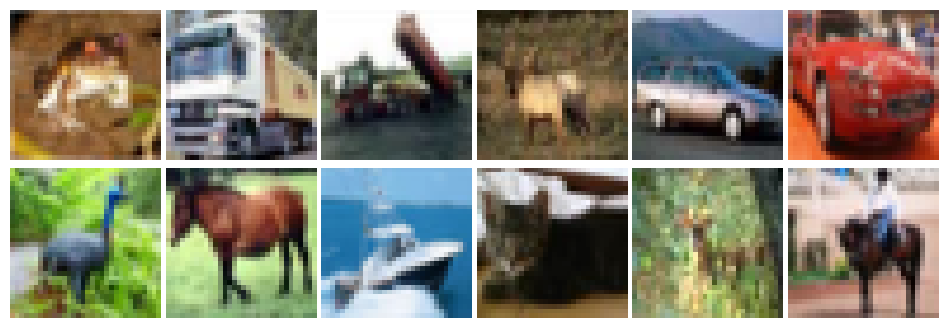

In [39]:
display_images(cifar10_tensor[:12])

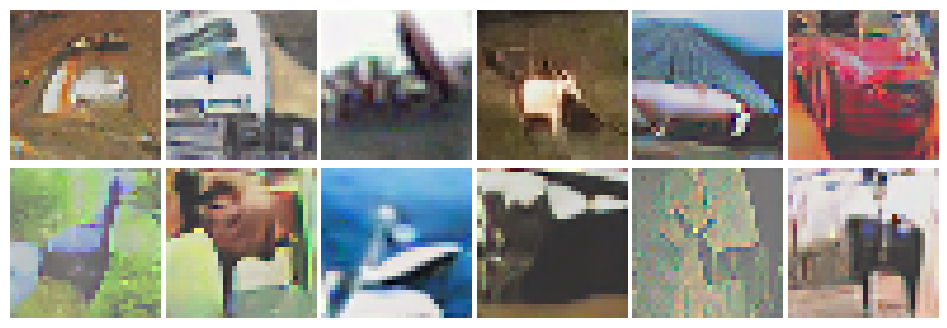

In [40]:
display_images(cifar10_reconstructed[:12])

# EBM Architecture

In [101]:
n_channels = 4
n_features = 64
leaky_slope = 0.2

class EnergyFunction(nn.Module):
    def __init__(self, n_c=n_channels, n_f=n_features, l=leaky_slope):
        super(EnergyFunction, self).__init__()
        
        # Neural network representing the energy function
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding
        self.f = nn.Sequential(
            # Input: (n_channels x 4 x 4)
            nn.Conv2d(n_c, n_f, 3, 1, 1),          # 4x4 -> 4x4 (due to padding of 1)
            nn.LeakyReLU(l),

            nn.Conv2d(n_f, n_f*2, 3, 1, 1),          # 4x4 -> 4x4 (due to padding of 1)
            nn.LeakyReLU(l),
            
            nn.Conv2d(n_f*2, 1, 4, 1, 0)         # 4x4 -> 1x1
        )
        
    def forward(self, x):
        return self.f(x).squeeze()

energy_func = EnergyFunction().to(device)

# EBM Training

Function to sample from our target data.

In [102]:
# Function to add Gaussian noise to data
def add_noise_to_data(data, sigma):
    return data + sigma * torch.randn_like(data)

# Sample from the preprocessed data distribution and add Gaussian noise
def sample_from_data_distribution(data_tensor, sigma):
    random_indices = torch.LongTensor(m).random_(0, data_tensor.shape[0])
    return add_noise_to_data(data_tensor[random_indices], sigma).detach()

Sampling using energy function's learned data distribution and MCMC.

In [103]:
latent_size = 4
m = 64           # Mini-batch size
K = 100          # Number of steps of MCMC

# Generate random noise
def generate_noise():
    return torch.FloatTensor(m, n_channels, latent_size, latent_size).uniform_(-1, 1).to(device)

# Sample using short-run MCMC from the model's distribution
def sample_from_model(f, K=K):
    samples = torch.autograd.Variable(generate_noise(), requires_grad=True)  # Create initial samples with noise and set requires_grad=True for gradient computation
    
    for _ in range(K):
        gradient = torch.autograd.grad(energy_func(samples).sum(), [samples], retain_graph=True)[0]  # Compute gradient of summed energy over all samples
        samples.data += gradient + 1e-2 * torch.randn_like(samples)                                  # Move towards gradient and add additional noise
        
    return samples.detach()  # Detach the tensor from the computation graph

## Training Loop

Create logging and save architecture in text file.

In [104]:
model_name = "ebm_128f_3conv"

model_train_dir = os.path.join("training", model_name)
if not os.path.exists(model_train_dir):
    os.makedirs(model_train_dir)

model_image_dir = os.path.join(model_train_dir, "ebm_images")
if not os.path.exists(model_image_dir):
    os.makedirs(model_image_dir)

model_arch_file = os.path.join(model_train_dir, "architecture.txt")
model_log_file = os.path.join(model_train_dir, "logs.txt")
model_weights_file = os.path.join(model_train_dir, "weights.pth")
model_train_status_file = os.path.join(model_train_dir, "train_status.json")

save_model_architecture(model_arch_file, energy_func)

In [105]:
def plot_images(path, images):
    torchvision.utils.save_image(torch.clamp(images, -1., 1.), 
                                 path, 
                                 normalize=True, 
                                 nrow=int(torch.sqrt(torch.Tensor([m]))))

Using the loss in training loop as a value for early stopping isn't good because it varies too much.

In [106]:
def load_train_status_json(file_path):
    try:
        with open(file_path, 'r') as file:
            train_status = json.load(file)
            prev_iter = train_status['prev_iter']
    except FileNotFoundError:
        prev_iter = 0
    
    return prev_iter

In [107]:
def save_train_status_json(file_path, curr_iter):
    train_status = {
        'prev_iter': curr_iter
    }
    with open(file_path, 'w') as file:
        json.dump(train_status, file)

Training loop.

In [109]:
lr = 1e-5
sigma = 3e-2     # decrease until training is unstable
optimizer = torch.optim.Adam(energy_func.parameters(), lr=lr, betas=[.9, .999])

# Load in from previous training loops
energy_func.load_state_dict(torch.load(model_weights_file))
prev_iter = load_train_status_json(model_train_status_file)
n_iters = 1000

# train
for i in range(prev_iter, prev_iter + n_iters):
    real_samples = sample_from_data_distribution(cifar10_latents, sigma)
    model_samples = sample_from_model(energy_func)
    
    # Compute loss as the difference in energy values of real and model samples
    loss = energy_func(real_samples).mean() - energy_func(model_samples).mean()

    # Backpropagation and optimization
    optimizer.zero_grad()
    (-loss).backward() # MLE, min -loss = max loss
    optimizer.step()

    # Save train status and weights
    save_train_status_json(model_train_status_file, i)
    torch.save(energy_func.state_dict(), model_weights_file)

    # Logging and visualization
    if i % 100 == 0:
        log_text = f'Iteration {i} | Real Sample Energy: {energy_func(real_samples).mean()} | Model Sample Energy: {energy_func(model_samples).mean()}'
        print(log_text)
        write_to_file(model_log_file, log_text)
        plot_images(f'{model_image_dir}/output_images_{i}.png', model_samples)

Iteration 23600 | Real Sample Energy: 8.237311363220215 | Model Sample Energy: 8.379100799560547
Iteration 23700 | Real Sample Energy: 8.209693908691406 | Model Sample Energy: 8.220893859863281
Iteration 23800 | Real Sample Energy: 8.180838584899902 | Model Sample Energy: 8.299646377563477
Iteration 23900 | Real Sample Energy: 8.47409439086914 | Model Sample Energy: 8.111833572387695
Iteration 24000 | Real Sample Energy: 8.224068641662598 | Model Sample Energy: 8.248525619506836
Iteration 24100 | Real Sample Energy: 8.208392143249512 | Model Sample Energy: 8.140169143676758
Iteration 24200 | Real Sample Energy: 8.235738754272461 | Model Sample Energy: 8.173934936523438
Iteration 24300 | Real Sample Energy: 7.899522304534912 | Model Sample Energy: 8.183685302734375
Iteration 24400 | Real Sample Energy: 7.857440948486328 | Model Sample Energy: 8.308059692382812
Iteration 24500 | Real Sample Energy: 8.288763046264648 | Model Sample Energy: 8.131226539611816


# Generation

In [116]:
def generate_images(n_generations, energy_func=energy_func, vae=vae):
    batch = sample_from_model(energy_func)
    with torch.no_grad():
        decoded_batch = vae.decode(batch).sample
    
    return decoded_batch[:n_generations]

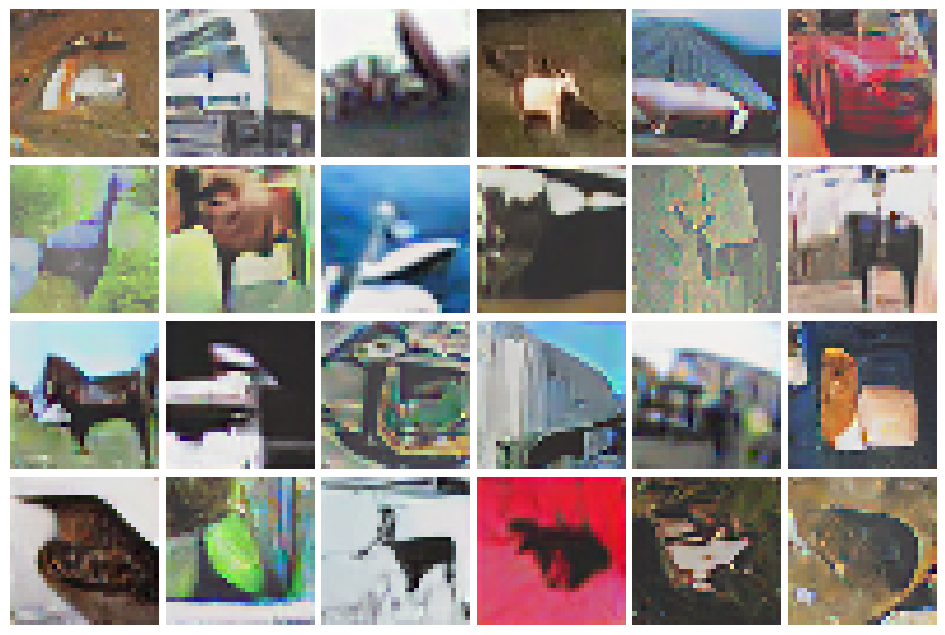

In [119]:
display_images(cifar10_reconstructed[:24])

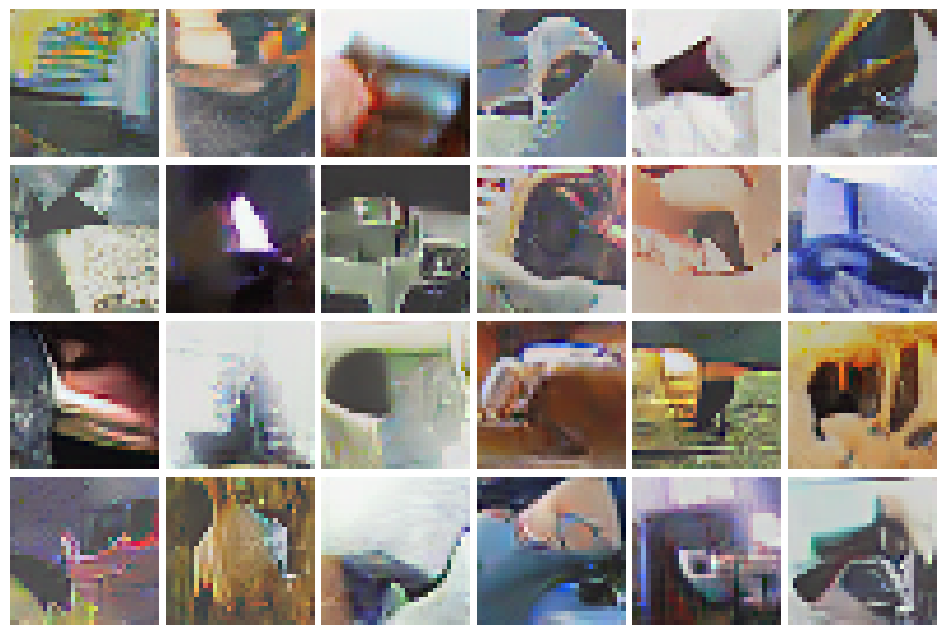

In [118]:
display_images(generate_images(24))